# SmartSifter

In [1]:
import os
import numpy as np
import numpy.random  as rd
import scipy as sp
from scipy import stats as st
from collections import Counter
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
import random
import math
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

## SDLEアルゴリズム

In [2]:
random.seed(0)
T = 500
x = np.array([math.floor(random.random()*3) for i in range(T)])

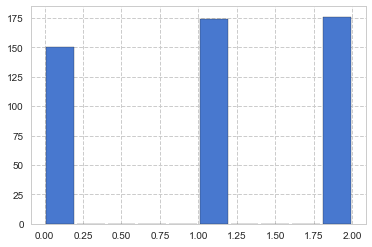

In [3]:
plt.hist(x, rwidth=0.9)
plt.show()

In [4]:
class SDLE:
    def __init__(self, r, beta, M, T):
        """
        """
        self.r = r
        self.beta = beta
        self.M = M
        self.T = T
        
        self.count = np.zeros((T+1, M))
        self.T_t = np.zeros((T+1, M))
        self.prob = np.zeros((T+1, M))
        
        self.t = 1
    
    def update(self, x_t):
        """
        オンライン学習
        """
        for i in range(self.M):
            delta = 0
            if i == x_t:
                delta = 1
                self.flag = x_t

            self.T_t[self.t, i] = (1 - self.r) * self.T_t[self.t-1, i] + delta
            self.count[self.t, i] = self.count[self.t-1, i] + delta
            if self.r == 0:
                q = (self.T_t[self.t, i] + self.beta) / (self.t + self.M * self.beta)
                # self.prob[self.t, i] = q / self.count[self.t, i]
                # self.prob[self.t, i] = q
            else:
                q = (self.T_t[self.t, i] + self.beta) / ((1 - (1 - self.r) ** self.t) / self.r + self.M * self.beta)
                # self.prob[self.t, i] = q
                # self.prob[self.t, i] = q / self.count[self.t, i]
            
            if not self.count[self.t, i] == 0:
                self.prob[self.t, i] = q / self.count[self.t, i]

        self.t += 1
    
    def train(self, x):
        """
        バッチ学習
        """
        while self.t <= self.T:
            self.update(x[self.t-1])

In [5]:
r = 1/T
beta = 1
M = len(np.unique(x))

sdle = SDLE(r, beta, M, T)
# print("t = %s" % sdle.t)
# print("count:\n", sdle.count)
# print("prob:\n",sdle.prob)

In [6]:
sdle.train(x)
sdle.t

501

In [7]:
p = sdle.prob[-1] * (1/sdle.prob[-1].sum())
p

array([ 0.33403711,  0.32866009,  0.3373028 ])

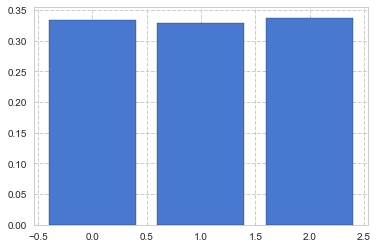

In [8]:
plt.bar(range(3), p)
plt.show()

## SDEMアルゴリズム

check:  0 [ 0.2  0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775
check:  1 [ 1.2  0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.002775
check:  2 [ 2.   0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775


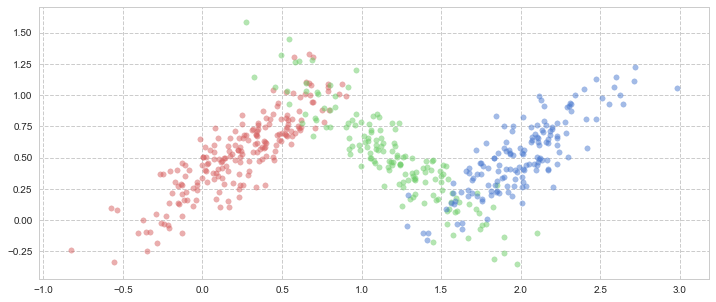

In [9]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

In [10]:
class SDEM:
    def __init__(self, r, alpha, k, T, d):
        """
        """
        self.r = r
        self.alpha = alpha
        self.k = k
        self.T = T+1
        self.d = d
        
        self.prob = np.zeros((self.T, self.k))
        self.mu = np.zeros((self.T, self.k, self.d))
        self.mu_ = np.zeros((self.T, self.k, self.d))
        self.pi = np.zeros((self.T, self.k))
        self.sigma = np.zeros((self.T, self.k, self.d, self.d))
        self.sigma_ = np.zeros((self.T, self.k, self.d, self.d))
        
        for i in range(self.k):
            self.pi[0, i] = 1 / self.k
            self.mu[0, i] = np.random.uniform(size=2)
            self.mu_[0, i] = self.mu[0, i] * self.pi[0, i]
            mu_tmp = self.mu[0, i].reshape((self.d, 1))
            self.sigma[0, i] = np.identity(self.d)# * 0.1
            self.sigma_[0, i] = (self.sigma[0, i] + np.dot(mu_tmp, mu_tmp.T)) * self.pi[0, i]
        self.t = 1
    
    def calc_prob(self, idy, pi, mu, sigma):
        p_ = np.zeros(self.k)
        p = np.zeros(self.k)
        for i in range(self.k):
            p[i] = st.multivariate_normal.pdf(idy, mu[i], sigma[i])
            p_[i] = pi[i]*p[i]
        return p, p_
    
    def update(self, idy):
        """
        """
        t = self.t
        for i in range(self.k):
            _, p_ = self.calc_prob(idy, self.pi[t-1], self.mu[t-1], self.sigma[t-1])
            gamma = ((1 - self.alpha * self.r) * (p_[i] / np.sum(p_))) + ((self.alpha * self.r) / self.k)
            
            self.pi[t, i] = ((1 - self.r) * self.pi[t-1, i]) + (self.r * gamma)
            self.mu_[t, i] = ((1 - self.r) * self.mu_[t-1, i]) + ((self.r * gamma) * idy)
            self.mu[t, i] = self.mu_[t, i] / self.pi[t, i]
            
            idy_tmp = idy.reshape((self.d, 1))
            mu_tmp = self.mu[t, i].reshape((self.d, 1))
            
            self.sigma_[t, i] = ((1 - self.r) * self.sigma_[t-1, i]) + ((self.r * gamma) * np.dot(idy_tmp, idy_tmp.T))
            self.sigma[t, i] = (self.sigma_[t, i] / self.pi[t, i]) - np.dot(mu_tmp, mu_tmp.T)
        p, _ = self.calc_prob(idy, self.pi[t], self.mu[t], self.sigma[t])
        self.prob[t] = p
            
        self.t += 1
        
    def skip(self):
        t = self.t
        for i in range(self.k):
            self.pi[t, i] = self.pi[t-1, i]
            self.mu[t, i] = self.mu[t-1, i]
            self.mu_[t, i] = self.mu_[t-1, i]
            self.sigma[t, i] = self.sigma[t-1, i]
            self.sigma_[t, i] = self.sigma_[t-1, i]
            self.prob[t] = self.prob[t-i, i]
        self.t += 1
    
    def train(self, y):
        """
        バッチ学習
        """
        while self.t < self.T:
            self.update(y[self.t-1])

In [11]:
alpha = 1.0
k = 3
T = data.shape[0]
d = data.shape[1]
r = 1/T

sdem = SDEM(r, alpha, k, T, d)

In [12]:
sdem.train(data)
#for j in range(30):
#    for i in range(500):
#        sdem.update(data[i])
#    sdem.t = 1

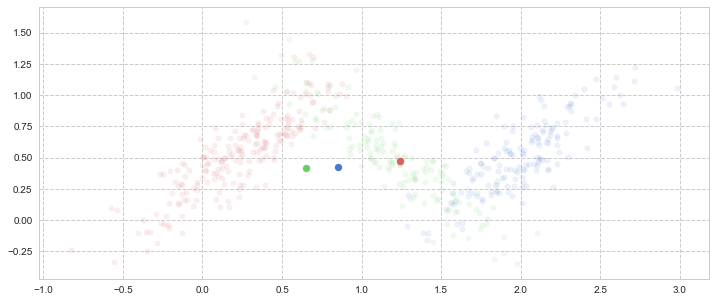

In [13]:
# plot generated data        
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.1)
#c_ = ["c", "m", "y"]
for i in range(3):
    plt.scatter(sdem.mu[-1, i, 0], sdem.mu[-1, i, 1], s=50, c=c[i])

In [14]:
x = x.reshape((500, 1))
y = data.copy()
Z = np.concatenate((x, y), axis=1)
Z = Z
# x
# X[:, 0]
# y
# X[:, 1:]

In [15]:
def hellinger_distance(mu, sigma, mu_prev, sigma_prev):
    mu = mu.reshape((mu.shape[0], 1))
    mu_prev = mu_prev.reshape((mu_prev.shape[0], 1))
    
    d_h = -(2*np.linalg.det((np.linalg.inv(sigma) + np.linalg.inv(sigma_prev))/2)**(-1/2))/(np.linalg.det(sigma)**(1/4)*np.linalg.det(sigma_prev)**(1/4))
    
    tmp = np.exp((1/2)*np.dot(np.dot(np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev).T, 
                              np.linalg.inv(np.linalg.inv(sigma)+np.linalg.inv(sigma_prev))),
                              np.dot(np.linalg.inv(sigma), mu + np.dot(np.linalg.inv(sigma_prev), mu_prev).T)))
    d_h *= np.exp(-(1/2)*(np.dot(np.dot(mu.T, np.linalg.inv(sigma)), mu) + np.dot(np.dot(mu_prev.T, np.linalg.inv(sigma_prev)), mu_prev)))
    d_h += 2
    return d_h

def calc_hellinger_distance(pi, pi_prev, mu, sigma, mu_prev, sigma_prev, k):
    d_H = 0
    for i in range(k):
        d_h = hellinger_distance(mu[i], sigma[i], mu_prev[i], sigma_prev[i])
        d_H += (pi[i] + pi_prev[i])/2 * d_h
    tmp = 0
    for i in range(k):
        tmp += np.sqrt(pi[i]) - np.sqrt(pi_prev[i]) ** 2
    d_H += tmp 
    return d_H

def calc_hellinger_score(p, p_prev, sdem, r, k, M):
    S_H = 0
    for m in range(M):
        d_H = calc_hellinger_distance(sdem[m].pi[sdem[m].t-1], sdem[m].pi[sdem[m].t-2] ,sdem[m].mu[sdem[m].t-1],
                                      sdem[m].sigma[sdem[m].t-1], sdem[m].mu[sdem[m].t-2], sdem[m].sigma[sdem[m].t-2], k)
        S_H += np.sqrt(p[m] * p_prev[m]) * d_H
    tmp = 0
    for m in range(M):
        tmp += np.sqrt(p[m] * p_prev[m])
    tmp *= 2
    S_H += 2 - tmp
    S_H /= r**2
    
    return S_H

In [16]:
# パラメータ設定
alpha = 1.0
k = 3
T = data.shape[0]
d = data.shape[1]
r = 1/T * 100
beta = 1
M = len(np.unique(x))

# オブジェクトの初期化
sdle = SDLE(r, beta, M, T)
sdem = [SDEM(r, alpha, k, T, d) for i in range(M)]

# 同時確率
p = []
# ヘリンジャースコア
S_H = []
# 対数損失
S_L = []

for i, z in enumerate(Z):
    sdle.update(z[0])
    # 各セルに対応する混合ガウス分布を推定
    for m in range(sdle.M):
        if m == int(sdle.flag):
            sdem[m].update(z[1:])
        else:
            sdem[m].skip()
        # tmp: p(y|x)
        tmp = np.dot(sdem[m].prob[sdem[m].t-1],sdem[m].pi[sdem[m].t-1])
    if i == 0:
        p_prev = 0
    else:
        p_prev = p[-1]
    p_t = tmp * sdle.prob[sdle.t-1, int(sdle.flag)]
    p.append(p_t)
    s_h = calc_hellinger_score(sdle.prob[sdle.t-1], sdle.prob[sdle.t-2], sdem, sdle.r, k, sdle.M)
    S_H.append(float(s_h))
    s_l = -np.log(p_prev)
    S_L.append(s_l)

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log
/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


In [17]:
df = pd.DataFrame(Z)
df.columns = ["x", "y1", "y2"]
df_S_L = pd.DataFrame(S_L)
df_S_H = pd.DataFrame(S_H)
df_S_L.columns = ["S_L"]
df_S_H.columns = ["S_H"]
df = pd.concat([df, df_S_L, df_S_H], axis=1)
#df = df[1:]
df.describe()

,x,y1,y2,S_L,S_H
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.052000,1.050635,0.517474,inf,50.229632
std,0.806596,0.808756,0.321666,NaN,0.760472
min,0.000000,-0.829006,-0.350895,1.952571,40.863968
25%,0.000000,0.343874,0.306160,3.742302,50.127426
50%,1.000000,1.059828,0.506927,4.442365,50.198926
75%,2.000000,1.781353,0.725453,5.125215,50.403359
max,2.000000,2.979137,1.586933,inf,51.351273


In [18]:
df.sort(columns="S_L",ascending=False).head()

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,x,y1,y2,S_L,S_H
0,2.0,0.074447,0.489028,inf,50.000000
355,0.0,1.944505,0.710984,13.697180,50.147208
357,2.0,1.948221,0.194424,13.655681,50.145401
211,2.0,1.092333,0.567220,12.660506,50.246157
209,0.0,0.649767,1.098103,12.644290,50.246045


In [19]:
df.sort(columns="S_H",ascending=False).head()

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,x,y1,y2,S_L,S_H
27,1.0,-0.001934,0.441918,3.449248,51.351273
26,1.0,0.388718,0.577588,2.354560,51.343725
31,2.0,0.312179,0.719204,3.311352,51.272766
28,2.0,-0.118374,0.157786,2.551697,51.259171
20,0.0,0.355308,0.476549,3.005316,51.239378
